In [331]:
import numpy as np
import libpysal as ps
import missingno as msno
from mgwr.gwr import GWR, MGWR, GWRResults
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.font_manager as fm
from matplotlib import font_manager, rc
import seaborn as sns
import warnings

warnings.simplefilter('ignore')

font_path = r'C:/Users/user/NanumFontSetup_TTF_ALL/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_path, size=18).get_name()
rc('font',family=font_name)

In [332]:
ped_data = pd.read_csv('./서울시_집계구_보행수요.csv',encoding="EUC-KR")
seoul_shp = gp.read_file('./data/서울시 행정구역 및 집계구 정보(SHP)/서울시_집계구_4326.shp',encoding="EUC-KR")
# pop_data = pd.read_csv('./data/pop/19년 12월 집계구코드별 평균생활인구수.csv')
display(seoul_shp.head())
display(ped_data.head)

,TOT_REG_CD,ADM_NM,ADM_CD,geometry
0,1101053010006,사직동,1101053,"POLYGON ((126.97033 37.57912, 126.97039 37.579..."
1,1101053010001,사직동,1101053,"POLYGON ((126.96613 37.57496, 126.96632 37.574..."
2,1101053010003,사직동,1101053,"POLYGON ((126.96645 37.57883, 126.96647 37.578..."
3,1101053010002,사직동,1101053,"POLYGON ((126.96877 37.57823, 126.96878 37.578..."
4,1101053010005,사직동,1101053,"POLYGON ((126.97399 37.57823, 126.97400 37.578..."


<bound method NDFrame.head of           TOT_REG_CD ADM_NM   ADM_CD  공공기관  보육시설  사회복지시  버스정류장  버스승하차  \
0      1101053010006    사직동  1101053     8     2      0      5   1269   
1      1101053010001    사직동  1101053     6     4      0      5    140   
2      1101053010003    사직동  1101053    10     6      0     13    492   
3      1101053010002    사직동  1101053     7     2      0      4   1390   
4      1101053010005    사직동  1101053    11     2      0      7   2165   
...              ...    ...      ...   ...   ...    ...    ...    ...   
19148  1102073010501    동화동  1102073     9     3      4      0      0   
19149  1102055030001     명동  1102055     5     2      0     13   1663   
19150  1102058040004    장충동  1102058     8     4      6      6    739   
19151  1121052010002   보라매동  1121052     4     7     11     14   1974   
19152  1121052010001   보라매동  1121052     4     5      3      8   1719   

       지하철(1km  지하철거리  승하차평균    구별총생활         구별총생_1  상가수_집  log생활  
0            2    450  5

In [333]:
ped_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19153 entries, 0 to 19152
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TOT_REG_CD  19153 non-null  int64  
 1   ADM_NM      19153 non-null  object 
 2   ADM_CD      19153 non-null  int64  
 3   공공기관        19153 non-null  int64  
 4   보육시설        19153 non-null  int64  
 5   사회복지시       19153 non-null  int64  
 6   버스정류장       19153 non-null  int64  
 7   버스승하차       19153 non-null  int64  
 8   지하철(1km     19153 non-null  int64  
 9   지하철거리       19153 non-null  int64  
 10  승하차평균       19153 non-null  int64  
 11  구별총생활       19153 non-null  int64  
 12  구별총생_1      19153 non-null  float64
 13  상가수_집       19143 non-null  float64
 14  log생활       19153 non-null  float64
dtypes: float64(3), int64(11), object(1)
memory usage: 2.2+ MB


In [334]:
seoul_shp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 19153 entries, 0 to 19152
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   TOT_REG_CD  19153 non-null  object  
 1   ADM_NM      19153 non-null  object  
 2   ADM_CD      19153 non-null  object  
 3   geometry    19153 non-null  geometry
dtypes: geometry(1), object(3)
memory usage: 598.7+ KB


In [335]:
seoul_shp.to_crs(epsg=4326)
seoul_shp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### 결측치 확인
- 상점의 수에 nan이 존재하여 0으로 대체

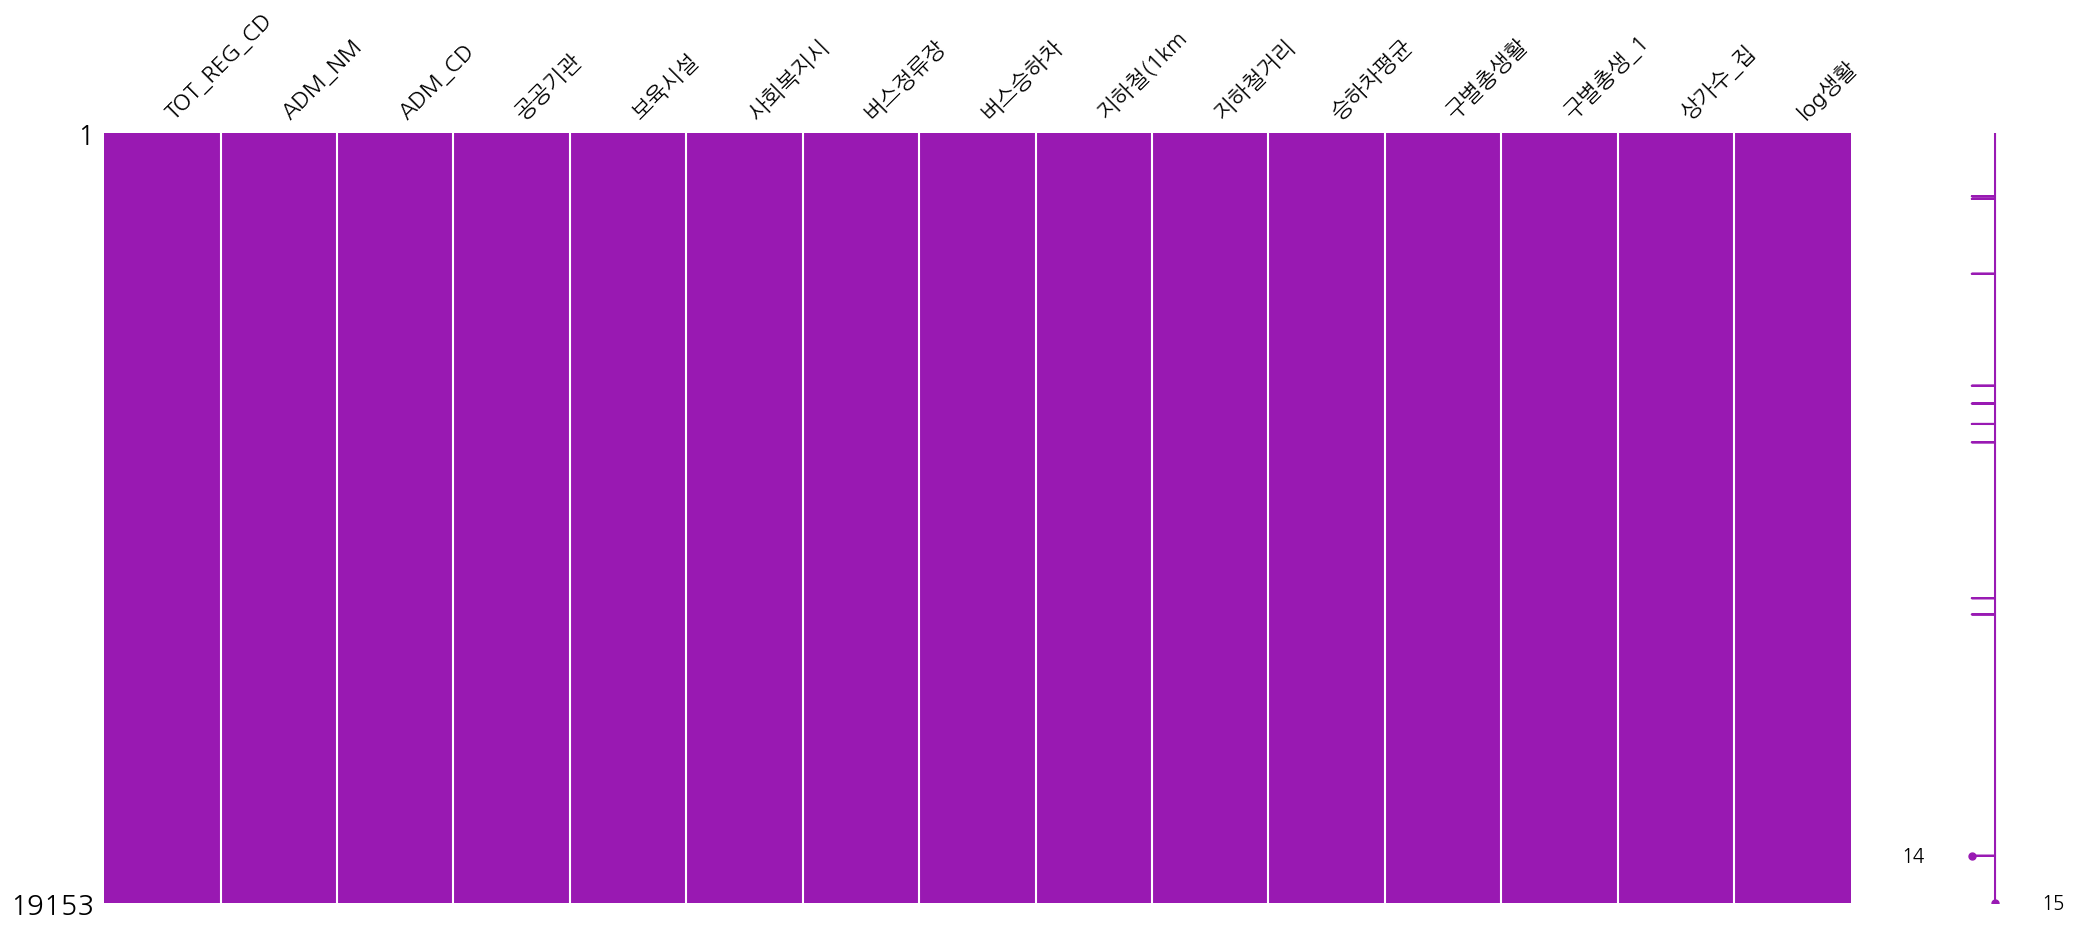

In [336]:
msno.matrix(df=ped_data,color=(0.6,0.1,0.7))
plt.show()

In [337]:
ped_data.isnull().sum()

TOT_REG_CD     0
ADM_NM         0
ADM_CD         0
공공기관           0
보육시설           0
사회복지시          0
버스정류장          0
버스승하차          0
지하철(1km        0
지하철거리          0
승하차평균          0
구별총생활          0
구별총생_1         0
상가수_집         10
log생활          0
dtype: int64

In [340]:
ped_data['SHOP_NUM'].fillna(0,inplace=True)
ped_data['SHOP_NUM'].isnull().sum()

0

### Column명 변경
- 사회복지시 -> SOC_NUM
- 지하철(1km -> SUB_NUM
- 지하철 거리 -> SUB_DIS
- 버스정류장 -> BUS_NUM
- 버스승하차 -> BUS_AVG
- 승하차평균 -> SUB_AVG
- 구별총생활 -> TOT_POP_GU
- 구별총생_1 -> TOT_POP_GU_AVG
- 상가수_집 -> SHOP_NUM

TARGET VARIABLE : TOT_POP_GU_AVG

In [339]:
ped_data.rename(columns={'사회복지시':'SOC_NUM','지하철(1km':'SUB_NUM','지하철거리':'SUB_DIS'
                         ,'버스정류장':'BUS_NUM','버스승하차':'BUS_AVG','승하차평균':'SUB_AVG'
                         ,'구별총생활':'TOT_POP_GU','구별총생_1':'TOT_POP_GU_AVG','상가수_집':'SHOP_NUM'}
                        ,inplace=True)      
ped_data.columns

Index(['TOT_REG_CD', 'ADM_NM', 'ADM_CD', '공공기관', '보육시설', 'SOC_NUM', 'BUS_NUM',
       'BUS_AVG', 'SUB_NUM', 'SUB_DIS', 'SUB_AVG', 'TOT_POP_GU',
       'TOT_POP_GU_AVG', 'SHOP_NUM', 'log생활'],
      dtype='object')

### 데이터 분포 확인
#### 1. 지하철 거리

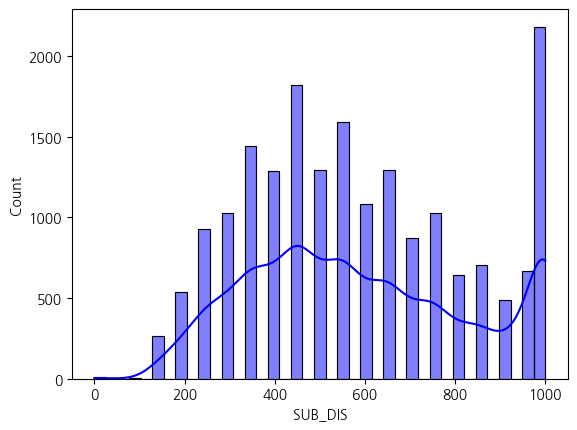

In [147]:
sns.histplot(data=ped_data,x='SUB_DIS',color='blue',kde=True)
plt.show()

#### 2. 버스 승하차
- 왼쪽으로 치우친 형태의 분포를 띄고 있다. 
- log함수를 이용하여 skew된 분포를 정규분포형태로 만들어주자.

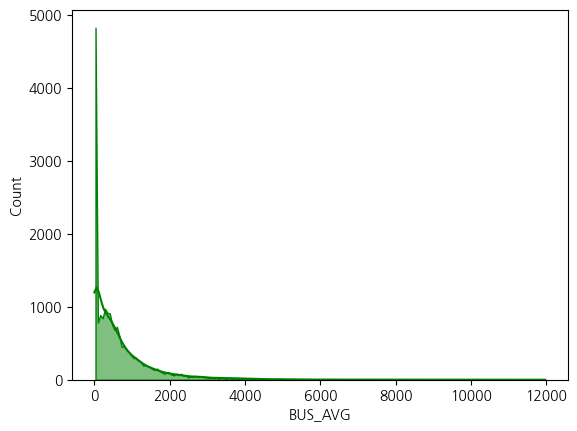

In [148]:
sns.histplot(data=ped_data,x='BUS_AVG',element="poly",color='green',kde=True)
plt.show()

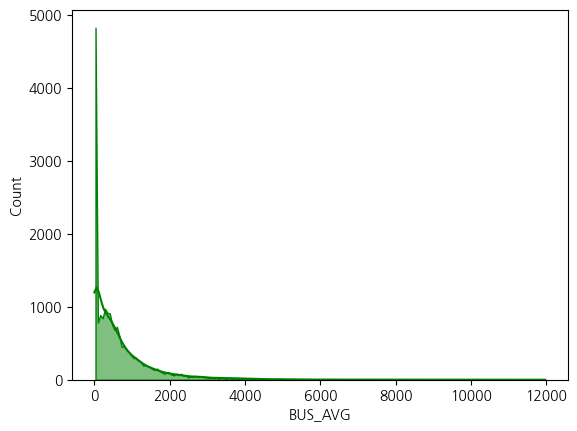

In [149]:
sns.histplot(data=ped_data,x='BUS_AVG',element="poly",color='green',kde=True)
plt.show()

#### 3. 지하철 평균
- 왼쪽으로 치우친 분포를 보이고 있다.
- log함수를 이용하여 정규분포 형태를 만들어주자.

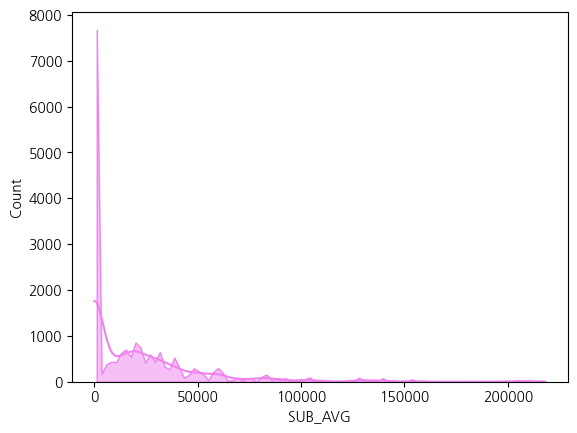

In [150]:
sns.histplot(data=ped_data,x='SUB_AVG',color='violet',element="poly",kde=True)
plt.show()

#### 4. 상가 수

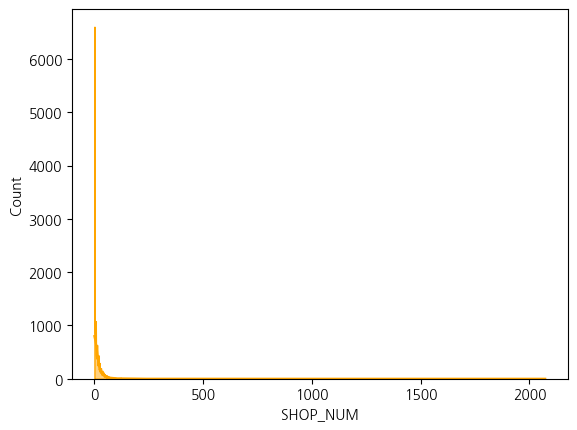

In [151]:
sns.histplot(data=ped_data,x='SHOP_NUM',color='orange',element="poly",kde=True)
plt.show()

#### 5. 구별총생활인구수 평균

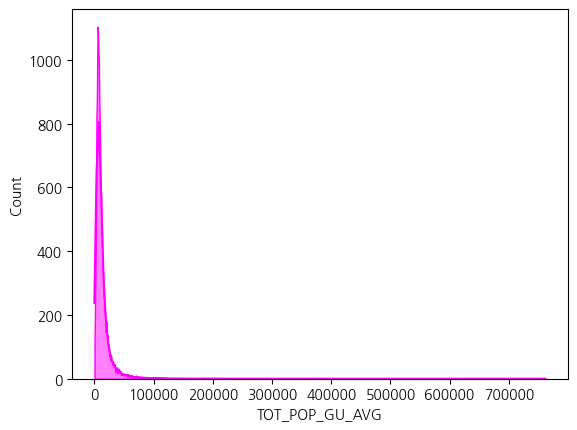

In [152]:
sns.histplot(data=ped_data,x='TOT_POP_GU_AVG',color='magenta',element="poly",kde=True)
plt.show()

In [341]:
# 현재 TOT_REG_CD가 int type이므로 str type으로 변경해주도록 한다.
# 차후 merge를 하기 위해서이다.
ped_data['TOT_REG_CD']= ped_data['TOT_REG_CD'].astype(str)

시설 수를 모두 합치자


In [342]:
ped_data['FACILITY_NUM'] = ped_data['공공기관']+ped_data['보육시설']+ped_data['SOC_NUM']

In [343]:
# prepare dataset
data = ped_data.merge(seoul_shp,left_on='TOT_REG_CD',right_on='TOT_REG_CD')
data.head()

,TOT_REG_CD,ADM_NM_x,ADM_CD_x,공공기관,보육시설,SOC_NUM,BUS_NUM,BUS_AVG,SUB_NUM,SUB_DIS,SUB_AVG,TOT_POP_GU,TOT_POP_GU_AVG,SHOP_NUM,log생활,FACILITY_NUM,ADM_NM_y,ADM_CD_y,geometry
0,1101053010006,사직동,1101053,8,2,0,5,1269,2,450,52315,367654,11859.806450,29.0,5.565,10,사직동,1101053,"POLYGON ((126.97033 37.57912, 126.97039 37.579..."
1,1101053010001,사직동,1101053,6,4,0,5,140,4,700,0,277143,8940.096774,7.0,5.443,10,사직동,1101053,"POLYGON ((126.96613 37.57496, 126.96632 37.574..."
2,1101053010003,사직동,1101053,10,6,0,13,492,4,600,34690,1245899,40190.290320,37.0,6.095,16,사직동,1101053,"POLYGON ((126.96645 37.57883, 126.96647 37.578..."
3,1101053010002,사직동,1101053,7,2,0,4,1390,3,450,52315,1373417,44303.774190,74.0,6.138,9,사직동,1101053,"POLYGON ((126.96877 37.57823, 126.96878 37.578..."
4,1101053010005,사직동,1101053,11,2,0,7,2165,3,300,52315,1038484,33499.483870,122.0,6.016,13,사직동,1101053,"POLYGON ((126.97399 37.57823, 126.97400 37.578..."


In [344]:
data.columns

Index(['TOT_REG_CD', 'ADM_NM_x', 'ADM_CD_x', '공공기관', '보육시설', 'SOC_NUM',
       'BUS_NUM', 'BUS_AVG', 'SUB_NUM', 'SUB_DIS', 'SUB_AVG', 'TOT_POP_GU',
       'TOT_POP_GU_AVG', 'SHOP_NUM', 'log생활', 'FACILITY_NUM', 'ADM_NM_y',
       'ADM_CD_y', 'geometry'],
      dtype='object')

In [345]:
# essential_col=['TOT_REG_CD','공공기관','보육시설','SOC_NUM','BUS_NUM','BUS_AVG','SUB_NUM','SUB_DIS','SUB_AVG'
#                ,'SHOP_NUM','geometry','TOT_POP_GU_AVG']
essential_col=['TOT_REG_CD','BUS_NUM','BUS_AVG','SUB_NUM','SUB_DIS','SUB_AVG'
               ,'SHOP_NUM','FACILITY_NUM','geometry','TOT_POP_GU_AVG']
required_data = data.loc[:,essential_col]
required_data.head()

,TOT_REG_CD,BUS_NUM,BUS_AVG,SUB_NUM,SUB_DIS,SUB_AVG,SHOP_NUM,FACILITY_NUM,geometry,TOT_POP_GU_AVG
0,1101053010006,5,1269,2,450,52315,29.0,10,"POLYGON ((126.97033 37.57912, 126.97039 37.579...",11859.806450
1,1101053010001,5,140,4,700,0,7.0,10,"POLYGON ((126.96613 37.57496, 126.96632 37.574...",8940.096774
2,1101053010003,13,492,4,600,34690,37.0,16,"POLYGON ((126.96645 37.57883, 126.96647 37.578...",40190.290320
3,1101053010002,4,1390,3,450,52315,74.0,9,"POLYGON ((126.96877 37.57823, 126.96878 37.578...",44303.774190
4,1101053010005,7,2165,3,300,52315,122.0,13,"POLYGON ((126.97399 37.57823, 126.97400 37.578...",33499.483870


### Data 분포 변환

#### 1. 버스 이용객 평균

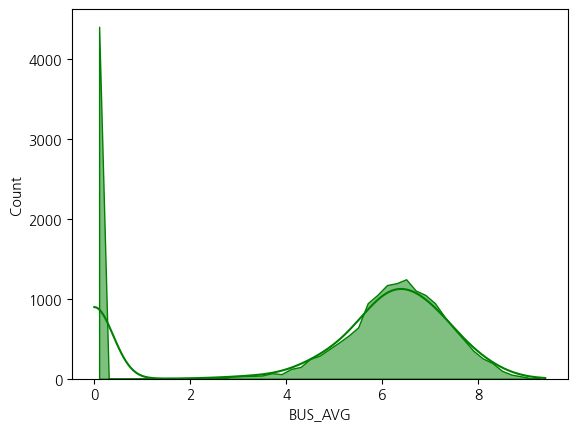

In [242]:
required_data.loc[:,'BUS_AVG'] = np.log1p(data['BUS_AVG'])
sns.histplot(data=required_data,x='BUS_AVG',element="poly",color='green',kde=True)
plt.show()

#### 2. 지하철 이용객 평균

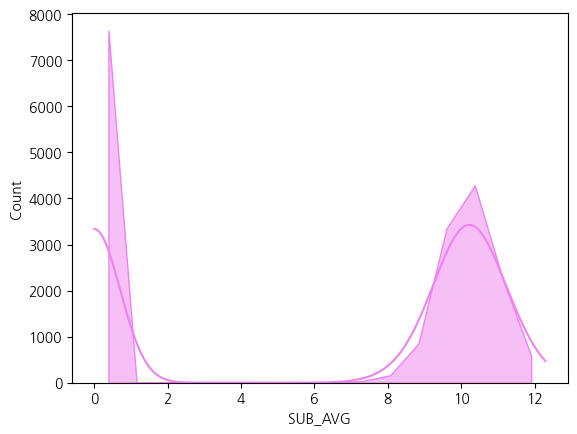

In [243]:
required_data.loc[:,'SUB_AVG'] = np.log1p(data['SUB_AVG'])
sns.histplot(data=required_data,x='SUB_AVG',color='violet',element="poly",kde=True)
plt.show()

#### 3. 상가 수

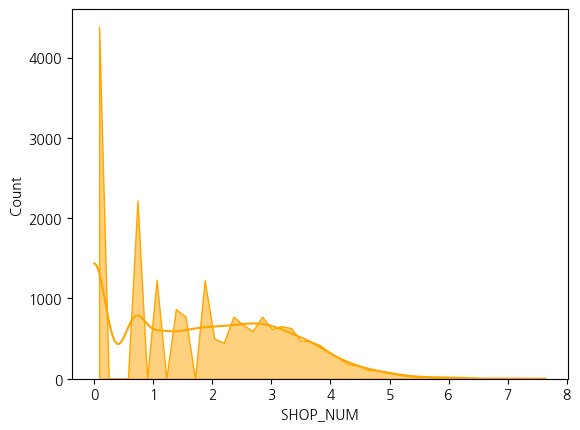

In [244]:
required_data.loc[:,'SHOP_NUM'] = np.log1p(data['SHOP_NUM'])
sns.histplot(data=required_data,x='SHOP_NUM',color='orange',element="poly",kde=True)
plt.show()

#### 4. 구별 총 생활인구 평균

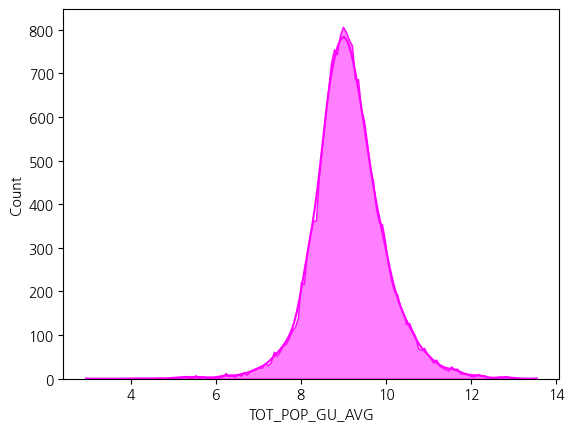

In [266]:
required_data.loc[:,'TOT_POP_GU_AVG'] = np.log1p(data['TOT_POP_GU_AVG'])
sns.histplot(data=required_data,x='TOT_POP_GU_AVG',color='magenta',element="poly",kde=True)
plt.show()

In [346]:
required_data['FACILITY_NUM'].agg(['min','max'])

min     0
max    55
Name: FACILITY_NUM, dtype: int64

In [347]:
center = seoul_shp.centroid
X = pd.Series(center.x)
Y = pd.Series(center.y)
required_data.loc[:,'lon'] = X
required_data.loc[:,'lat'] = Y
required_data.head()

,TOT_REG_CD,BUS_NUM,BUS_AVG,SUB_NUM,SUB_DIS,SUB_AVG,SHOP_NUM,FACILITY_NUM,geometry,TOT_POP_GU_AVG,lon,lat
0,1101053010006,5,1269,2,450,52315,29.0,10,"POLYGON ((126.97033 37.57912, 126.97039 37.579...",11859.806450,126.970311,37.578304
1,1101053010001,5,140,4,700,0,7.0,10,"POLYGON ((126.96613 37.57496, 126.96632 37.574...",8940.096774,126.965178,37.574151
2,1101053010003,13,492,4,600,34690,37.0,16,"POLYGON ((126.96645 37.57883, 126.96647 37.578...",40190.290320,126.965513,37.576513
3,1101053010002,4,1390,3,450,52315,74.0,9,"POLYGON ((126.96877 37.57823, 126.96878 37.578...",44303.774190,126.969002,37.577092
4,1101053010005,7,2165,3,300,52315,122.0,13,"POLYGON ((126.97399 37.57823, 126.97400 37.578...",33499.483870,126.972772,37.578025


### 독립변수, 종속변수 설정

In [348]:
essential_col[1:-2]
# 합침 : 사회복지, 기관, 보육시설 다 합침.

['BUS_NUM',
 'BUS_AVG',
 'SUB_NUM',
 'SUB_DIS',
 'SUB_AVG',
 'SHOP_NUM',
 'FACILITY_NUM']

In [349]:
#Prepare Georgia dataset inputs
s_y = required_data['TOT_POP_GU_AVG'].values.reshape((-1,1))
s_X = required_data[essential_col[1:-2]].values
u = required_data['lon']
v = required_data['lat']
s_coords = list(zip(u,v))

### Train and Test set 분리

In [233]:
s_y = sample_data['구별총생활인구수(월평균)'].values.reshape((-1,1))
s_X = sample_data[['정류장수', '월평균승차수', '월평균하차수','lon','lat']].values
u = sample_data['lon']
v = sample_data['lat']
coords = list(zip(u,v))

# standardScaler적용

# scaler = StandardScaler()
# s_y = required_data['TOT_POP_GU_AVG']
# s_X = required_data[['정류장수', '월평균승차수', '월평균하차수','lon','lat']]

# train set과 test set으로 나누는 과정으로 보인다.
# 해당 모델에 교차 검증이 있는 것으로 알고 있다.

# test set은 20%, 
# x_train, x_valid, y_train, y_valid = train_test_split(s_X, s_y, test_size=0.2, shuffle=True,random_state=34)

# cal_u = x_train['lon'].values
# cal_v = x_train['lat'].values
# cal_coords = list(zip(cal_u,cal_v))

# pred_u = x_valid['lon'].values
# pred_v = x_valid['lat'].values
# pred_coords = list(zip(pred_u,pred_v))

# # 위도, 경도 column 제거
# # display(x_train.columns)
# x_train.drop(['lon','lat'],axis=1,inplace=True)
# x_valid.drop(['lon','lat'],axis=1,inplace=True)

# # array로 변환
# X_train = scaler.fit_transform(x_train.values)
# Y_train = scaler.fit_transform(y_train.values.reshape((-1,1)))
# X_valid = scaler.fit_transform(x_valid.values)
# Y_valid = scaler.fit_transform(y_valid.values.reshape((-1,1)))

NameError: name 'sample_data' is not defined

### Modeling

In [350]:
#Calibrate GWR model
gwr_selector = Sel_BW(s_coords, s_y, s_X,kernel='gaussian')
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y, s_X, gwr_bw,kernel='gaussian')
gwr_results = gwr_model.fit()

16.0


In [351]:
gwr_results.critical_tval(.05)

1.960087857692249

In [352]:
gwr_results.params[0:5]

array([[-4.14497464e+04,  6.38089238e+02, -3.33658578e+00,
         6.86973127e+03,  3.40288309e+01,  4.58940774e-02,
         5.09153699e+02,  4.08707676e+02],
       [ 4.20813200e+03, -2.84090694e+02, -3.26343820e+00,
         3.30006103e+03, -8.01958816e+00, -6.91360449e-02,
         5.74232456e+02,  1.79373857e+01],
       [ 3.75848450e+03,  2.26386400e+02, -3.92411259e+00,
         2.99096385e+03, -3.36013490e+00, -3.99546448e-02,
         5.26782574e+02, -2.10007283e+02],
       [-2.27882227e+04,  6.95772363e+02, -4.36776530e+00,
         5.54309752e+03,  1.98654289e+01, -1.58128729e-02,
         5.53308400e+02, -6.75036946e+01],
       [-5.49594812e+04,  5.77258320e+02, -1.33754309e-01,
         7.87672603e+03,  3.82434256e+01,  8.42468242e-03,
         4.73409462e+02,  1.05486820e+03]])

In [353]:
gwr_results.localR2[0:10]

array([[0.91807908],
       [0.90368048],
       [0.90586052],
       [0.93201888],
       [0.89429727],
       [0.92068654],
       [0.91683747],
       [0.90838173],
       [0.91637634],
       [0.89845762]])

### 모델링 결과 확인

In [354]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                               19153
Number of covariates:                                                     8

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       4175357232016.704
Log-likelihood:                                                 -211045.791
AIC:                                                             422107.582
AICc:                                                            422109.591
BIC:                                                           4175357043242.895
R2:                                                                   0.558
Adj. R2:                                                              0.558

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- -------

### 계수 시각화

In [ ]:
display(len(sample_data))
display(len(gwr_results.params))
# sample_data에 서울의 polygon이 들어있으므로 이를 활용하여 시각화하자.
visualization_data = required_data.copy()
visualization_data.head()

In [ ]:
#Prepare GWR results for mapping

#Add GWR parameters to GeoDataframe
visualization_data['gwr_intercept'] = gwr_results.params[:,0]
visualization_data['gwr_bus_stop'] = gwr_results.params[:,1]
visualization_data['gwr_avg_ride'] = gwr_results.params[:,2]
visualization_data['gwr_avg_get_off'] = gwr_results.params[:,3]

#Obtain t-vals filtered based on multiple testing correction
gwr_filtered_t = gwr_results.filter_tvals()

In [ ]:
#Prep plot and add axes
fig, ax = plt.subplots(1, figsize=(30,20))
ax.set_title('GWR Bus Stop Surface (BW: ' + str(gwr_bw) +')', fontsize=40)

#Set color map
cmap = plt.cm.seismic

#Find min and max values of the two combined datasets
vmin = s_geo_data['gwr_bus_stop'].min()
vmax = s_geo_data['gwr_bus_stop'].max()

#If all values are negative use the negative half of the colormap
if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
#If all values are positive use the positive half of the colormap
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
#Otherwise, there are positive and negative values so the colormap so zero is the midpoint
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
s_geo_data.plot('gwr_bus_stop', cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (gwr_filtered_t[:,0] == 0).any():
    s_geo_data[gwr_filtered_t[:,0] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})
 
#Set figure options and plot 
fig.tight_layout()    
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=50) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

### 예측 모델 생성

In [313]:
# standardScaler적용

col = essential_col[1:-2]
col.append('lon')
col.append('lat')
display(col)
s_y = required_data['TOT_POP_GU_AVG']
s_X = required_data[col]

# test set은 20%, 
x_train, x_valid, y_train, y_valid = train_test_split(s_X, s_y, test_size=0.2, shuffle=True,random_state=34)

cal_u = x_train['lon'].values
cal_v = x_train['lat'].values
cal_coords = list(zip(cal_u,cal_v))

pred_u = x_valid['lon'].values
pred_v = x_valid['lat'].values
pred_coords = list(zip(pred_u,pred_v))

# 위도, 경도 column 제거
# display(x_train.columns)
x_train.drop(['lon','lat'],axis=1,inplace=True)
x_valid.drop(['lon','lat'],axis=1,inplace=True)

# array로 변환
X_train = x_train.values
Y_train = y_train.values.reshape((-1,1))
X_valid = x_valid.values
Y_valid = y_valid.values.reshape((-1,1))

['BUS_NUM',
 'BUS_AVG',
 'SUB_NUM',
 'SUB_DIS',
 'SUB_AVG',
 'SHOP_NUM',
 'FACILITY_NUM',
 'lon',
 'lat']

In [314]:
#Calibrate GWR model
gwr_selector = Sel_BW(cal_coords, Y_train, X_train,kernel='gaussian')
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(cal_coords, Y_train, X_train, gwr_bw,kernel='gaussian')
gwr_results = gwr_model.fit()

17.0


In [325]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                               15322
Number of covariates:                                                     8

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       3442867949650.949
Log-likelihood:                                                 -169064.159
AIC:                                                             338144.317
AICc:                                                            338146.329
BIC:                                                           3442867802069.242
R2:                                                                   0.556
Adj. R2:                                                              0.556

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- -------

In [315]:
scale = gwr_results.scale
residuals = gwr_results.resid_response
# 
display(type(pred_coords))
# test data로 예측을 해보고 결과 저장
pred_results = gwr_model.predict(np.array(pred_coords), X_valid, scale, residuals)

list

In [317]:
np.corrcoef(pred_results.predictions.flatten(), Y_valid.flatten())
# [0][1]

array([[1.        , 0.77760647],
       [0.77760647, 1.        ]])

In [318]:
import scipy.stats as stats

In [319]:
F_statistic, pVal = stats.f_oneway(pred_results.predictions.flatten(),Y_valid.flatten())

print('Altman 910 데이터의 일원분산분석 결과 : F={0:.1f}, p={1:.5f}'.format(F_statistic, pVal))
if pVal < 0.05:
    print('P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.')

Altman 910 데이터의 일원분산분석 결과 : F=3.0, p=0.08504


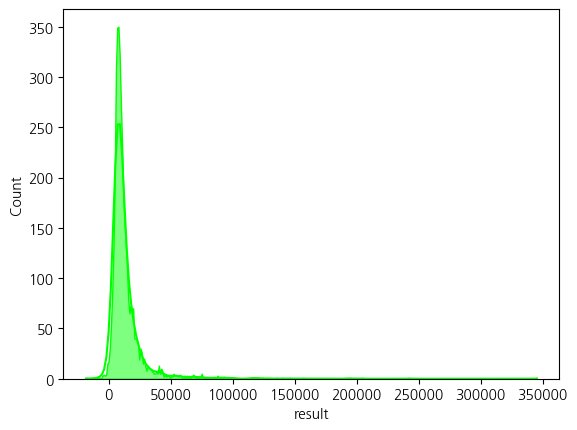

In [327]:
pred = pd.DataFrame(pred_results.predictions,columns={'result'})
valid = pd.DataFrame(Y_valid,columns={'result'})
sns.histplot(data=pred,x='result',color='lime',element="poly",kde=True)
plt.show()

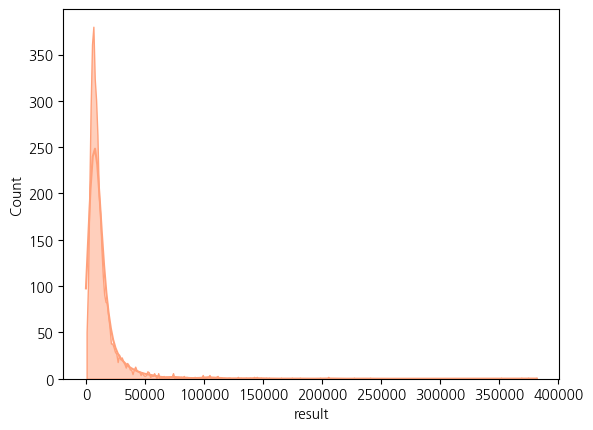

In [328]:
sns.histplot(data=valid,x='result',color='lightsalmon',element="poly",kde=True)
plt.show()

### 교차검증 코드

In [ ]:
# # standardScaler적용

# col = essential_col[1:-2]
# col.append('lon')
# col.append('lat')
# display(col)
# s_y = required_data['TOT_POP_GU_AVG']
# s_X = required_data[col]

# # test set은 20%, 
# x_train, x_valid, y_train, y_valid = train_test_split(s_X, s_y, test_size=0.2, shuffle=True,random_state=34)

# # 이 과정을 함수로 만들어서 교차 검증을 수행하도록 하자.
# # ------------------------------
# # 이 아래부터 함수로 구현하면 될 것 같다.
# # 그리고 coords, x_train, y_train을 형식에 맞춰서 반환하면 될것같다.

In [ ]:
# # 교차 검증에서 모델에 데이터를 적용하기 위한 전처리 함수
# def gwr_dataset(x,y):
#     display(x)
#     u = x['lon'].values
#     v = x['lat'].values
#     coords = list(zip(u,v))
#     display('success')
#     # 위도, 경도 column 제거
#     x_train.drop(['lon','lat'],axis=1,inplace=True)

#     # array로 변환
#     X = x_train.values
#     Y = y_train.values.reshape((-1,1))

#     return coords, X, Y

# #Calibrate GWR model
# def gwr_model_process(cal_coords, Y_train,X_train):
#     gwr_selector = Sel_BW(cal_coords, Y_train, X_train,kernel='gaussian')
#     gwr_bw = gwr_selector.search(bw_min=2)
#     gwr_model = GWR(cal_coords, Y_train, X_train, gwr_bw,kernel='gaussian')
#     gwr_results = gwr_model.fit()
    
#     return gwr_model, gwr_results  

# def gwr_predict(gwr_models,gwr_results,X_valid,pred_coodrs):
#     scale = gwr_results.scale
#     residuals = gwr_results.resid_response
#     pred_results = gwr_model.predict(np.array(pred_coords), X_valid, scale, residuals)
#     result = pred_results.predictions
#     return result

In [ ]:
# # 교차검증 시 각  fold 별로 평가지표를 저장하여 평균할 수 있도록 하자.
# # R2, Adj. R2

# col = essential_col[1:-2]
# col.append('lon')
# col.append('lat')
# s_y = required_data['TOT_POP_GU_AVG']
# s_X = required_data[col]

# # test set은 20%, 
# X_train, X_test, y_train, y_test = train_test_split(s_X, s_y, test_size=0.2, shuffle=True,random_state=34)

# oof_train = np.zeros((y_train.shape[0],))
# oof_test = np.zeros((y_test.shape[0],))

# cv_list=[]

# # Kfold 정의
# kfolds = KFold(n_splits=5, random_state=1993, shuffle=True)

# # Fold별로 학습진행
# for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = X_train, y = y_train ) ) ):
    
#     # Train/Valid-set을 정의하기
#     display(ind)
#     display(X_train.iloc[trn_ind])
#     local_coords_train ,local_X_train, local_y_train = gwr_dataset(X_train.iloc[trn_ind], y_train[trn_ind])
#     local_coords_valid, local_X_valid , local_y_valid = gwr_dataset(X_train.iloc[val_ind], y_train[val_ind])
#     local_coords_test, local_X_test, local_y_test = gwr_dataset(X_test,y_test)
    
#     print("---TRAINING GWR---")
#     # GWR model 정의&학습
#     gwr_model, gwr_result = gwr_model_process(local_coords_train, local_X_train, local_y_train)
    
#     gwr_model.summary()
#     # local_valid/local_test에 대한 예측
#     gwr_valid_pred = gwr_predict(gwr_model,gwr_results,local_X_valid,local_coords_valid)
#     gwr_test_pred = gwr_predict(gwr_model,gwr_results,local_X_test,local_coords_test)
    
#     cv_list.append(sqrt(mean_squared_error(local_y_valid,gwr_valid_pred)))
    
#     oof_train[val_ind] = gwr_valid_pred
#     oof_test += gwr_test_pred/n_splits
    
#     print('='*80)
    
# print(f"<LOCAL_TRAIN> OVERALL RMSE : {sqrt( mean_squared_error( y_train, oof_train ) )}")
# print(f"<LOCAL_TEST>  OVERALL RMSE : {sqrt( mean_squared_error( y_test, oof_test ) )}")